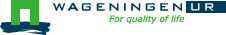



# Advanced agromanagement with PCSE/WOFOST

This notebook will demonstrate how to implement advanced agromanagement options with PCSE/WOFOST.

Allard de Wit, April 2018

For the example we will assume that data files are in the data directory within the directory where this notebook is located. This will be the case if you downloaded the notebooks from github.

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for plotting results


In [12]:
%matplotlib inline
import os, sys

import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import yaml

import pcse
from pcse.models import Wofost71_WLP_FD
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider
from pcse.base_classes import ParameterProvider
data_dir = os.path.join(os.getcwd(), "data")

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:13) [MSC v.1500 32 bit (Intel)] 
PCSE version: 5.3.2


## Input requirements
For running the PCSE/WOFOST (and PCSE models in general), you need three types of inputs:
1. Model parameters that parameterize the different model components. These parameters usually
   consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters
   and a set of site parameters. The latter provide ancillary parameters that are specific for a location.
2. Driving variables represented by weather data which can be derived from various sources.
3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated
   by PCSE.

## Reading model parameters
In this example, we will derive the model parameters from different sources. First of all, the crop parameters will be read from my [github repository](https://github.com/ajwdewit/WOFOST_crop_parameters) using the `YAMLCropDataProvider`. Next, the soil parameters will be read from a classical CABO input file using the `CABOFileReader`. Finally, the site parameters can be defined directly using the `WOFOST71SiteDataProvider` which provides sensible defaults for site parameters. 

However, PCSE models expect a single set of parameters and therefore they need to be combined using the `ParameterProvider`:

In [13]:
crop = YAMLCropDataProvider()
soil = CABOFileReader(os.path.join(data_dir, "soil", "ec3.soil"))
site = WOFOST71SiteDataProvider(WAV=100,CO2=360)
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)

## Reading weather data
For reading weather data we will use the NASAPowerWeatherDataProvider. 

In [14]:
from pcse.fileinput import ExcelWeatherDataProvider
weatherfile = os.path.join(data_dir, 'meteo', 'nl1.xlsx')
weatherdataprovider = ExcelWeatherDataProvider(weatherfile)


## Defining agromanagement with timed events

Defining agromanagement needs a bit more explanation because agromanagement is a relatively
complex piece of PCSE. The agromanagement definition for PCSE is written in a format called `YAML` and for a thorough discusion have a look at the [Section on Agromanagement](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-agromanager) in the PCSE manual.
For the current example the agromanagement definition looks like this:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_date: 2006-03-31
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:
        -   event_signal: irrigate
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:
            - 2006-07-10: {amount: 10, efficiency: 0.7}
            - 2006-08-05: {amount:  5, efficiency: 0.7}
        StateEvents: null

The agromanagement definition starts with `Version:` indicating the version number of the agromanagement file
while the actual definition starts after the label `AgroManagement:`. Next a date must be provide which sets the
start date of the campaign (and the start date of the simulation). Each campaign is defined by zero or one
CropCalendars and zero or more TimedEvents and/or StateEvents. The CropCalendar defines the crop type, date of sowing,
date of harvesting, etc. while the Timed/StateEvents define actions that are either connected to a date or
to a model state.

In the current example, the campaign starts on 2006-01-01, there is a crop calendar for sugar beet starting on
2006-03-31 with a harvest date of 2006-10-20. Next there are timed events defined for applying irrigation at 2006-07-10 and 2006-08-05. The current example has no state events. For a thorough description of all possibilities see the section on AgroManagement in the Reference Guide.

Loading the agromanagement definition from a file can be done with the `YAMLAgroManagementReader`. However for this example, we can just as easily define it here and parse it directly with the YAML parser. In this case we can directly use the section after the `Agromanagement:` label.

In [15]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 2006-07-10: {amount: 10, efficiency: 0.7}
        - 2006-08-05: {amount:  5, efficiency: 0.7}
    StateEvents: null
"""
agromanagement = yaml.load(yaml_agro)

## Starting and running the WOFOST
We have now all parameters, weather data and agromanagement information available to start WOFOST and make a simulation.

In [16]:
wofost = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
wofost.run_till_terminate()

## Getting and visualizing results

Next, we can easily get the output from the model using the get_output() method and turn it into a pandas DataFrame:

In [17]:
output = wofost.get_output()
df = pd.DataFrame(output).set_index("day")
df.tail()

,DVS,LAI,RD,SM,TAGP,TRA,TWLV,TWRT,TWSO,TWST,WWLOW
day,,,,,,,,,,,
2006-10-16,2.176179,1.202331,120.0,0.274528,23351.179606,0.058482,4749.874750,3725.984299,13887.927703,4713.377153,32.943365
2006-10-17,2.182750,1.209976,120.0,0.274019,23427.632097,0.033733,4753.697375,3727.544553,13956.734945,4717.199777,32.882291
2006-10-18,2.190321,1.190275,120.0,0.275722,23459.431607,0.033126,4755.287350,3728.193523,13985.354504,4718.789753,33.086619
2006-10-19,2.198464,1.193119,120.0,0.275951,23487.868075,0.047238,4756.709173,3728.773859,14010.947325,4720.211576,33.114121
2006-10-20,2.207321,1.168128,120.0,0.275374,23520.561112,0.042466,4758.343825,3729.441064,14040.371058,4721.846228,33.044867


Finally, we can visualize the results from the pandas DataFrame with a few commands:

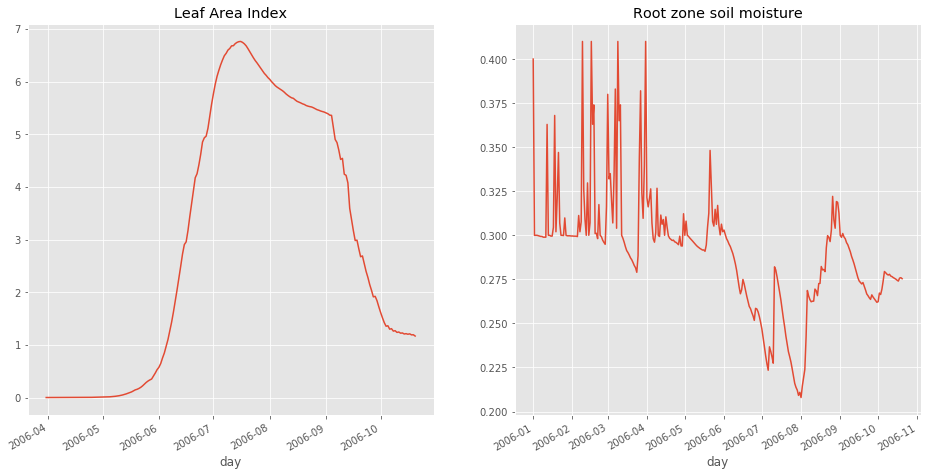

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
df['LAI'].plot(ax=axes[0], title="Leaf Area Index")
df['SM'].plot(ax=axes[1], title="Root zone soil moisture")
fig.autofmt_xdate()

# Defining agromanagement with state events

## Connecting events to development stages
It is also possible to connect irrigation events to state variables instead of dates. A logical approach is to connect an irrigation even to a development stage instead of a date, in this way changes in the sowing date will be automatically reflected in changes in irrigation events.

For this we need to change the definition of the agromanagement as below:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents: null
        StateEvents:
        -   event_signal: irrigate
            event_state: DVS
            zero_condition: rising
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:
            - 0.9: {amount: 10, efficiency: 0.7}
            - 1.5: {amount:  5, efficiency: 0.7}
    - 2006-11-20: null
       
In this case the irrigation events are connected to the state DVS and are occurring when the simulated DVS crosses the values 0.9 and 1.5. Note that there two additional parameters: `event_state` which defines the state to which the event is connected and `zero_condition` which specifies the condition under which the state event fires, see for an explanation [here](http://pcse.readthedocs.org/en/latest/code.html#agromanagement). Finally, also note that there must be an "empty trailing campaign" defined which defines that the campaign that starts at 2006-01-01 ends at 2006-11-20. Otherwise PCSE cannot determine the end of the simulation period, see also the link above for an explanation.

Again, we will define the agromanagement directly on the command line and parse it with YAML.

In [19]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents:
    -   event_signal: irrigate
        event_state: DVS
        zero_condition: rising
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 0.9: {amount: 10, efficiency: 0.7}
        - 1.5: {amount:  5, efficiency: 0.7}
- 2006-11-20: null
"""
agromanagement = yaml.load(yaml_agro)

Again we run the model with all inputs but a changed agromanagement and plot the results

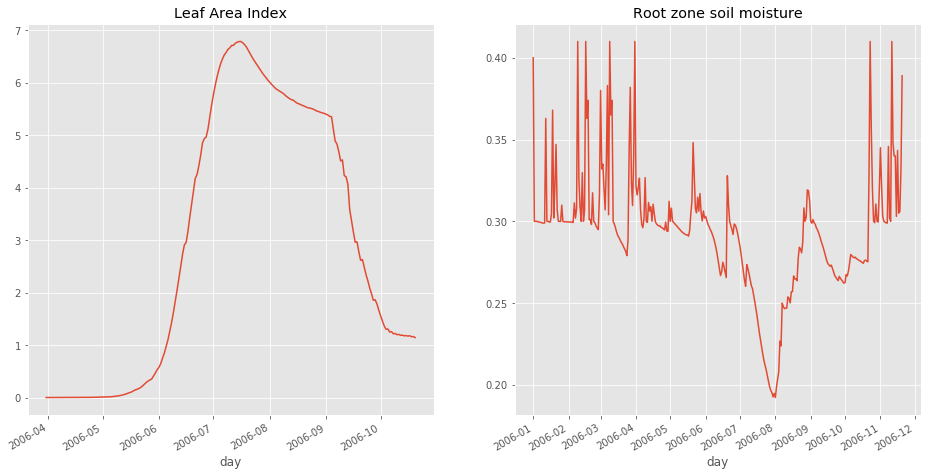

In [20]:
wofost2 = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
wofost2.run_till_terminate()
output2 = wofost2.get_output()
df2 = pd.DataFrame(output2).set_index("day")
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
df2['LAI'].plot(ax=axes2[0], title="Leaf Area Index")
df2['SM'].plot(ax=axes2[1], title="Root zone soil moisture")
fig2.autofmt_xdate()

## Connecting  events to soil moisture levels

The logical approach is to connect irrigation events to stress levels that are experiences by the crop. In this case we connect the irrigation event to the state variables soil moisture (SM) and define the agromanagement like this:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_date: 2006-03-31
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents: null
        StateEvents:
        -   event_signal: irrigate
            event_state: SM
            zero_condition: falling
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:
            - 0.2: {amount: 10, efficiency: 0.7}
    - 2006-11-20:
    
Note that in this case the `zero_condition` is `falling` because we only want the event to trigger when the SM goes below the specified level (0.2). If we had set `zero_condition` to `either` it would trigger twice, the first time when the soil moisture gets exhausted and the second time because of the irrigation water added.

In [21]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents:
    -   event_signal: irrigate
        event_state: SM
        zero_condition: falling
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 0.2: {amount: 10, efficiency: 0.7}
- 2006-11-20: null
"""
agromanagement = yaml.load(yaml_agro)

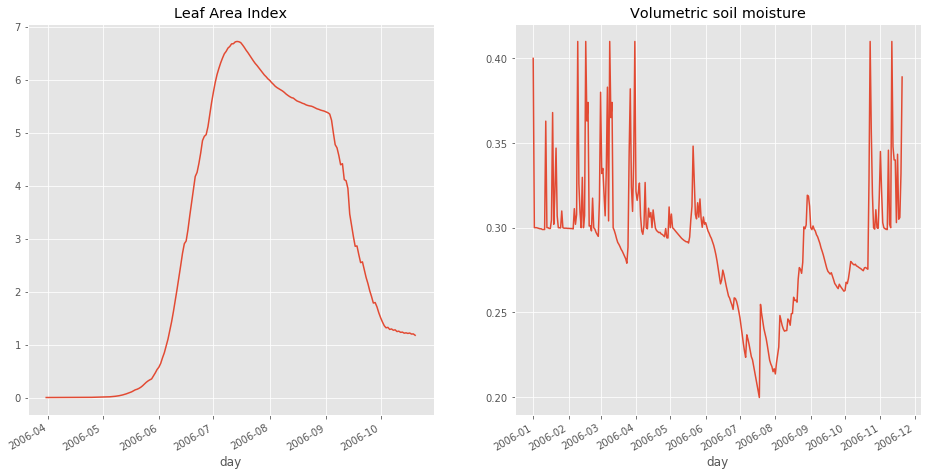

In [22]:
wofost3 = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
wofost3.run_till_terminate()
output3 = wofost3.get_output()
df3 = pd.DataFrame(output3).set_index("day")

fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
df3['LAI'].plot(ax=axes3[0], title="Leaf Area Index")
df3['SM'].plot(ax=axes3[1], title="Volumetric soil moisture")
fig3.autofmt_xdate()

Showing the differences in irrigation events
============================================

We combine the `SM`  column from the different data frames in a new dataframe and plot the results to see the effect of the differences in agromanagement.

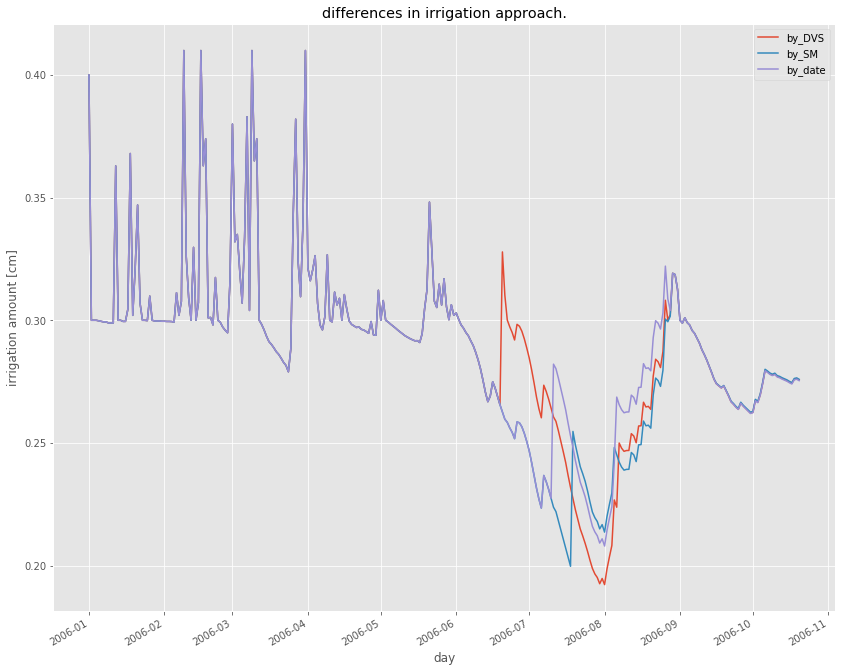

In [23]:
df_all = pd.DataFrame({"by_date": df.SM, 
                       "by_DVS": df2.SM, 
                       "by_SM": df3.SM}, index=df.index)
fig4, axes4 = plt.subplots(nrows=1, ncols=1, figsize=(14,12))
df_all.plot(ax=axes4, title="differences in irrigation approach.")
axes4.set_ylabel("irrigation amount [cm]")
fig4.autofmt_xdate()

Adjusting the sowing date with the AgroManager and making multiple runs
==============================================

The most straightforward way of adjusting the sowing date is by editing the crop management definition in YAML format directly. Here we put a placeholder `{crop_start_date}` at the point where the crop start date is defined in the YAML format. We can then use string formatting operations to insert a new data and use `yaml.load` to load the definition in yaml directly. Note that we need double curly brackets (`{{` and `}}`) at the events table to avoid that python sees them as a placeholder.

In [24]:
agromanagement_yaml = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: {crop_start_date}
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents:
    -   event_signal: irrigate
        event_state: SM
        zero_condition: falling
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 0.2: {{amount: 10, efficiency: 0.7}}
- 2006-11-20:
"""

## The main loop for making several WOFOST runs

In [25]:
import datetime as dt
sdate = dt.date(2006,3,1)
step = 10
# Loop over six different start dates 
results = []
for i in range(6):
    # get new start date
    csdate = sdate + dt.timedelta(days=i*step)
    # update agromanagement with new start date and load it with yaml.load
    tmp = agromanagement_yaml.format(crop_start_date=csdate)
    agromanagement = yaml.load(tmp)
    # run wofost and collect output
    wofost = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
    wofost.run_till_terminate()
    output = wofost.get_output()
    df = pd.DataFrame(output).set_index("day")
    results.append(df)

##  Plot the results for the different runs and variables

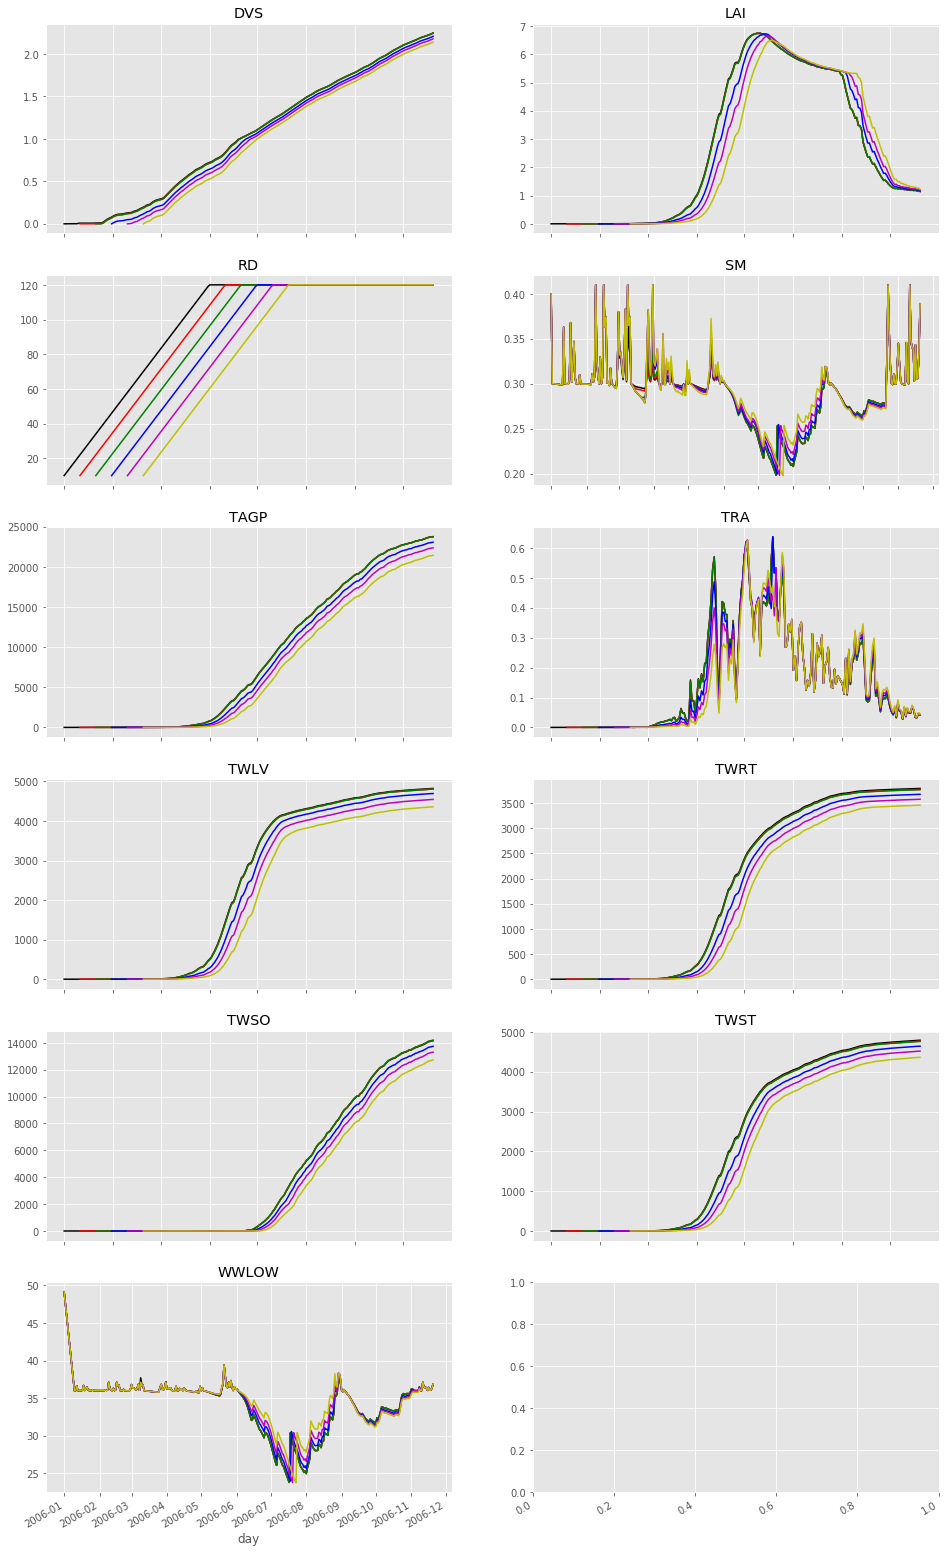

In [26]:
colors = ['k','r','g','b','m','y']
fig5, axes5 = plt.subplots(nrows=6, ncols=2, figsize=(16,30))
for c, df in zip(colors, results):
    for key, axis in zip(df.columns, axes5.flatten()):
        df[key].plot(ax=axis, title=key, color=c)
fig5.autofmt_xdate()